In [1]:
import itk
from itk import TubeTK as ttk

import numpy as np
import struct
import matplotlib.pyplot as plt

from itkwidgets import view

In [2]:
with open('Data/bmenv2.dat', mode='rb') as file:
    fileContent = file.read()

In [3]:
dt = np.dtype(np.float64)
dt = dt.newbyteorder('<')
data_1d = np.frombuffer(fileContent, dtype=dt)

In [4]:
nlateral = 92
nframes = 200  #200
ndepth = 153
nelevation = 102

In [5]:
data_raw = np.reshape(data_1d, [nlateral,nframes,ndepth,nelevation], order='C')

In [6]:
data = np.transpose(data_raw, (1,3,0,2))

In [7]:
fixed_id = 0
moving_id = 29

In [8]:
img = itk.GetImageFromArray(data[fixed_id,:,:,:])
immath = ttk.ImageMath(Input=img)

itkImageF4 not loaded from module TubeTK because of exception:
 module 'itk.TubeTKPython' has no attribute 'itkImageF4'
vectoritkImageF4 not loaded from module TubeTK because of exception:
 module 'itk.TubeTKPython' has no attribute 'vectoritkImageF4'


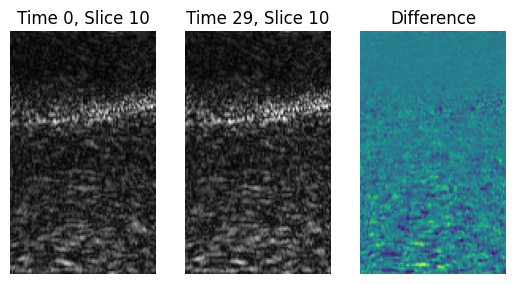

In [9]:
f, pltarr = plt.subplots(1,3)
pltarr[0].imshow(np.rot90(data[fixed_id,10,:,:],3),"gray")
pltarr[0].axis('off')
pltarr[0].title.set_text('Time 0, Slice 10')
pltarr[1].imshow(np.rot90(data[moving_id,10,:,:],3),"gray")
pltarr[1].axis('off')
pltarr[1].title.set_text('Time 29, Slice 10')
pltarr[2].imshow(np.rot90(data[fixed_id,10,:,:]-data[moving_id,10,:,:],3))
pltarr[2].axis('off')
pltarr[2].title.set_text('Difference')


In [10]:
view(data[fixed_id,:,:,:])

<IPython.core.display.Javascript object>

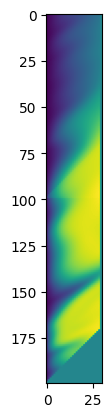

In [11]:
offset = 30
diff = np.zeros([data.shape[0],offset])
for i in range(data.shape[0]):
    jmin = min(i+1,data.shape[0])
    jmax = min(i+offset,data.shape[0])
    for j in range(jmin,jmax):
        diff[i,j-i-1] = np.sum(np.abs(data[i,:,:,:]-data[j,:,:,:]))
diff_avg = np.average(diff)
diff = np.where(diff==0,diff_avg,diff)
plt.imshow(diff)

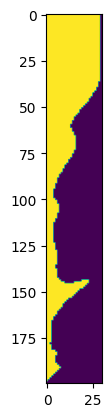

In [12]:
datai = np.where(diff<diff_avg,1,0)
plt.imshow(datai)

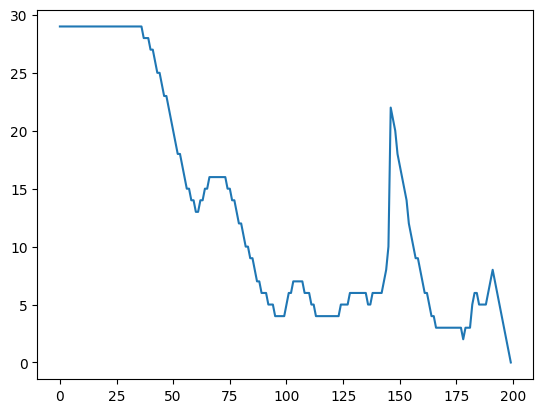

In [13]:
datar = np.argmin(datai,axis=1)
plt.plot(datar)

In [14]:
fixed_list = []
moving_list = []
fixed = 0
while fixed<data.shape[0]-1:
    moving = fixed+datar[fixed]
    fixed_list.append(fixed)
    moving_list.append(moving)
    print(f"{fixed} - {moving}")
    fixed = moving

0 - 29
29 - 58
58 - 72
72 - 88
88 - 95
95 - 99
99 - 103
103 - 110
110 - 116
116 - 120
120 - 124
124 - 129
129 - 135
135 - 141
141 - 147
147 - 168
168 - 171
171 - 174
174 - 177
177 - 180
180 - 183
183 - 189
189 - 195
195 - 199


In [15]:
fixed_id = fixed_list[0]
moving_id = moving_list[0]

window = max((moving_id-fixed_id)//5,1)
print(f"{fixed_id} {moving_id} {window}")

fixed_min = int(max(fixed_id-window,0))
fixed_max = int(min(fixed_id+window,data.shape[0]))

moving_min = int(max(moving_id-window,0))
moving_max = int(min(moving_id+window,data.shape[0]))

tmp_fixed = np.average(data[fixed_min:fixed_max],axis=0)
tmp_moving = np.average(data[moving_min:moving_max],axis=0)

img_fixed = itk.GetImageFromArray(tmp_fixed.astype(np.float32))
img_fixed_blur = itk.SmoothingRecursiveGaussianImageFilter(img_fixed,sigma=3)
tmp_fixed_blur = itk.GetArrayFromImage(img_fixed_blur)

img_moving = itk.GetImageFromArray(tmp_moving.astype(np.float32))
img_moving_blur = itk.SmoothingRecursiveGaussianImageFilter(img_moving,sigma=3)
tmp_moving_blur = itk.GetArrayFromImage(img_moving_blur)

tmp_diff = tmp_fixed_blur - tmp_moving_blur

0 29 5


<Figure size 640x480 with 0 Axes>

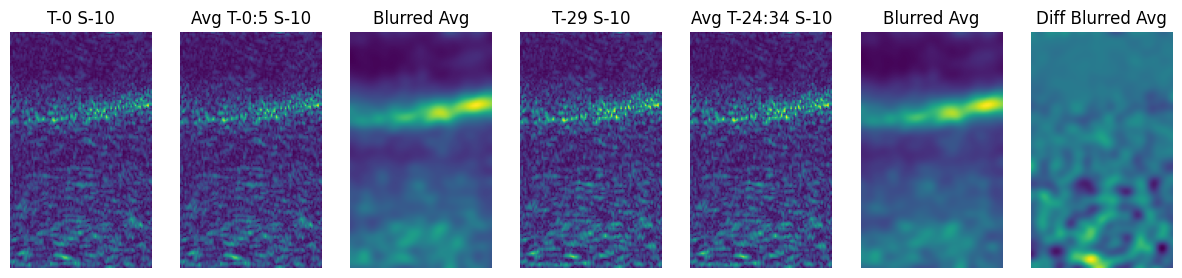

<Figure size 640x480 with 0 Axes>

In [16]:
f, pltarr = plt.subplots(1,7)
f.set_figwidth(15)
f.set_figheight(4)
pltarr[0].imshow(np.rot90(data[fixed_id,10,:,:],3))
pltarr[0].axis('off')
pltarr[0].title.set_text('T-0 S-10')
pltarr[1].imshow(np.rot90(tmp_fixed[10,:,:],3))
pltarr[1].axis('off')
pltarr[1].title.set_text('Avg T-0:5 S-10')
pltarr[2].imshow(np.rot90(tmp_fixed_blur[10,:,:],3))
pltarr[2].axis('off')
pltarr[2].title.set_text('Blurred Avg')
pltarr[3].imshow(np.rot90(data[moving_id,10,:,:],3))
pltarr[3].axis('off')
pltarr[3].title.set_text('T-29 S-10')
pltarr[4].imshow(np.rot90(tmp_moving[10,:,:],3))
pltarr[4].axis('off')
pltarr[4].title.set_text('Avg T-24:34 S-10')
pltarr[5].imshow(np.rot90(tmp_moving_blur[10,:,:],3))
pltarr[5].axis('off')
pltarr[5].title.set_text('Blurred Avg')
pltarr[6].imshow(np.rot90(tmp_diff[10,:,:],3))
pltarr[6].axis('off')
pltarr[6].title.set_text('Diff Blurred Avg')
plt.figure()

In [17]:
view(tmp_fixed_blur)

<IPython.core.display.Javascript object>

In [18]:
def prep(data, t, window):
    t_min = int(max(t-window,0))
    t_max = int(min(t+window,data.shape[0]))

    tmp_data = np.average(data[t_min:t_max],axis=0)

    img_data = itk.GetImageFromArray(tmp_data.astype(np.float32))
    img_data_blur = itk.SmoothingRecursiveGaussianImageFilter(img_data,sigma=5)
    tmp_data_blur = itk.GetArrayFromImage(img_data_blur)
    
    return tmp_data_blur, img_data_blur

offset = 30
window = 1
diff = np.zeros([data.shape[0],offset])
for i in range(data.shape[0]):
    data_i,img_i = prep(data, i, window)
    jmin = min(i+1,data.shape[0])
    jmax = min(i+offset,data.shape[0])
    for j in range(jmin,jmax):
        data_j,img_j = prep(data, j, window)
        diff[i,j-i-1] = np.sum(np.abs(data_j-data_i))

In [19]:
diff_avg = np.average(diff)
diff = np.where(diff==0,diff_avg+1,diff)

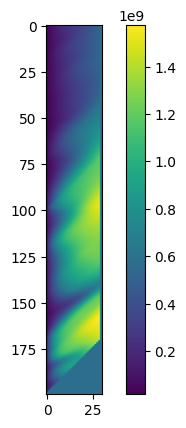

In [20]:
f = plt.figure()
p = plt.imshow(diff)
f.colorbar(p)

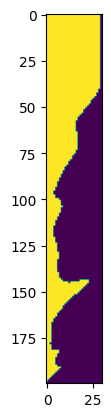

In [21]:
datai = np.where(diff<diff_avg,1,0)
plt.imshow(datai)

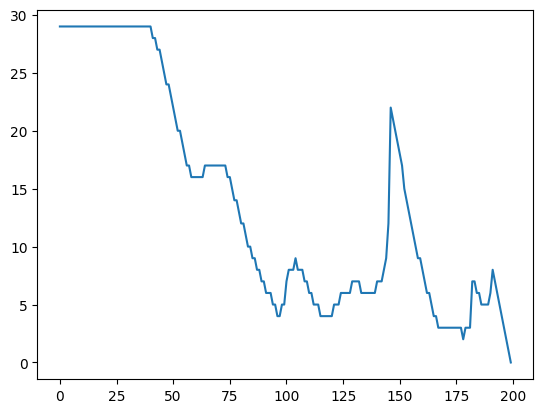

In [22]:
datar = np.argmin(datai,axis=1)
plt.plot(datar)

In [23]:
fixed_list = []
moving_list = []
fixed = 0
while fixed<data.shape[0]-1:
    moving = fixed+datar[fixed]
    fixed_list.append(fixed)
    moving_list.append(moving)
    print(f"{fixed} - {moving}")
    fixed = moving
print(len(fixed_list))

0 - 29
29 - 58
58 - 74
74 - 90
90 - 97
97 - 101
101 - 109
109 - 116
116 - 120
120 - 124
124 - 130
130 - 137
137 - 143
143 - 151
151 - 168
168 - 171
171 - 174
174 - 177
177 - 180
180 - 183
183 - 190
190 - 196
196 - 199
23


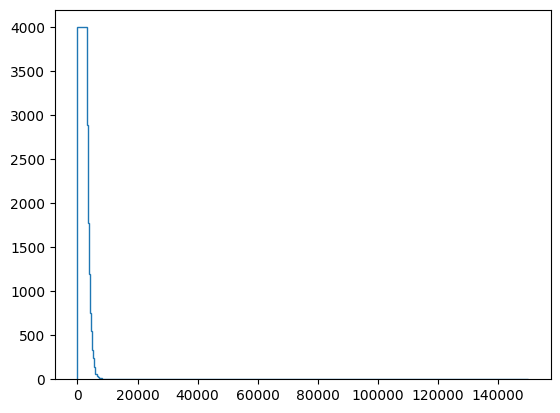

In [24]:
data_fixed_blur, img_fixed_blur = prep(data, 0, window)
data_moving_blur, img_moving_blur = prep(data, 29, window)
tmp_diff = data_fixed_blur-data_moving_blur
tmp_counts, tmp_bins = np.histogram(np.abs(tmp_diff.flatten()),bins=500,range=(0,150000))
tmp_counts = np.where(tmp_counts>4000,4000, tmp_counts)
plt.stairs(tmp_counts, tmp_bins)

In [25]:
Reg = ttk.RegisterImages[itk.Image[itk.F,3]].New()
Reg.SetFixedImage(img_fixed_blur)
Reg.SetMovingImage(img_moving_blur)
Reg.SetReportProgress(True)
Reg.SetRegistration("PIPELINE_AFFINE")
Reg.SetMetric("MATTES_MI_METRIC")
#Reg.SetMetric("MEAN_SQUARED_ERROR_METRIC")

Reg.SetExpectedOffsetMagnitude(100)
Reg.SetExpectedRotationMagnitude(0.1)
Reg.SetRigidSamplingRatio(0.2)
Reg.SetRigidMaxIterations(10000)

Reg.SetExpectedScaleMagnitude(0.05)
Reg.SetExpectedSkewMagnitude(0.001)
Reg.SetAffineSamplingRatio(0.2)
Reg.SetAffineMaxIterations(2000)
#Reg.SetUseEvolutionaryOptimization(False)

import time

start_t = time.perf_counter()
Reg.Update()
end_t = time.perf_counter()

In [26]:
print(f"Time required = {end_t-start_t}")
print("")
print(Reg.GetCurrentMatrixTransform())

Time required = 64.0296205

AffineTransform (0000021697E4A050)
  RTTI typeinfo:   class itk::AffineTransform<double,3>
  Reference Count: 3
  Modified Time: 6526941
  Debug: Off
  Object Name: 
  Observers: 
    none
  Matrix: 
    1 -0.000789832 -0.00145938 
    0.00078218 0.999983 -0.00535556 
    0.0014638 0.00535443 0.999983 
  Offset: [0.112867, 0.24363, 0.0168416]
  Center: [76, 46, 51]
  Translation: [0.00233636, 0.0291811, 0.373522]
  Inverse: 
    0.999994 0.000782004 0.00146358 
    -0.000790006 0.999987 0.00535443 
    -0.00145959 -0.00535559 0.999986 
  Singular: 0



In [27]:
img_moving_reg = Reg.GetFinalMovingImage()

In [28]:
data_moving_reg = itk.GetArrayFromImage(img_moving_reg)

In [29]:
pre_diff = (data_fixed_blur - data_moving_blur)**2
pre_diff = np.where(data_fixed_blur>0,pre_diff,0)
pre_diff = np.where(data_moving_blur>0,pre_diff,0)
pre_diff_size = np.count_nonzero(pre_diff>0)
pre_diff_mse = pre_diff.sum() / pre_diff_size
pre_diff = pre_diff**0.5

reg_diff = (data_fixed_blur - data_moving_reg)**2
reg_diff = np.where(data_fixed_blur>0,reg_diff,0)
reg_diff = np.where(data_moving_reg>0,reg_diff,0)
reg_diff_size = np.count_nonzero(reg_diff>0)
reg_diff_mse = reg_diff.sum() / reg_diff_size
reg_diff = reg_diff**0.5

tmpdiff1 = reg_diff.max()
tmpdiff2 = pre_diff.max()
maxdiff = max(tmpdiff1,tmpdiff2)
reg_diff[0,0,0]=maxdiff
pre_diff[0,0,0]=maxdiff

print(pre_diff_mse)
print(reg_diff_mse)

287196.6048931883
266349.24946629006



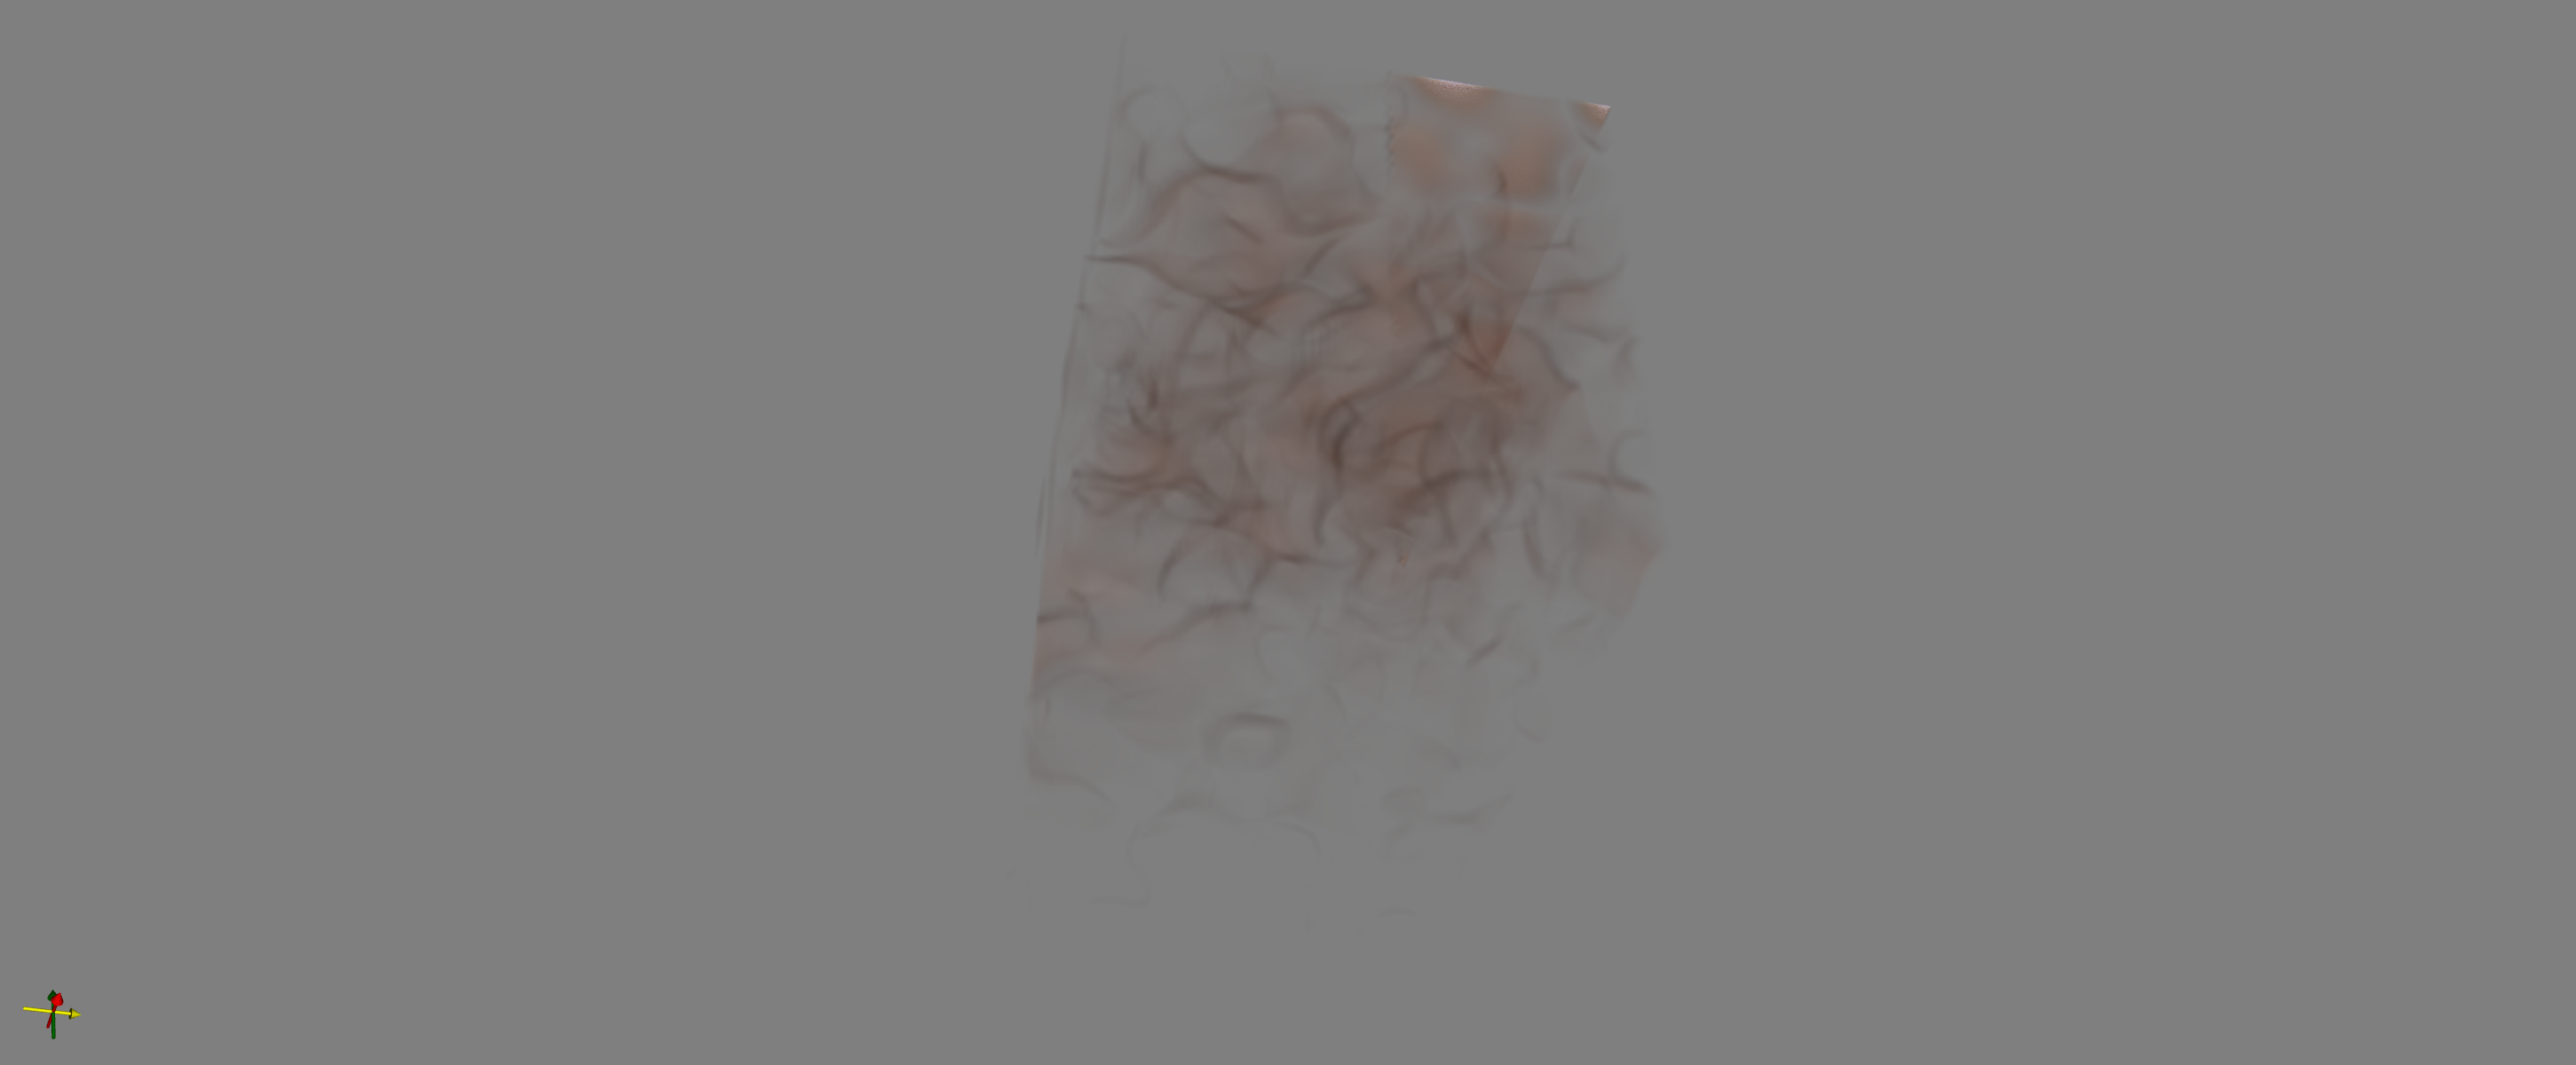
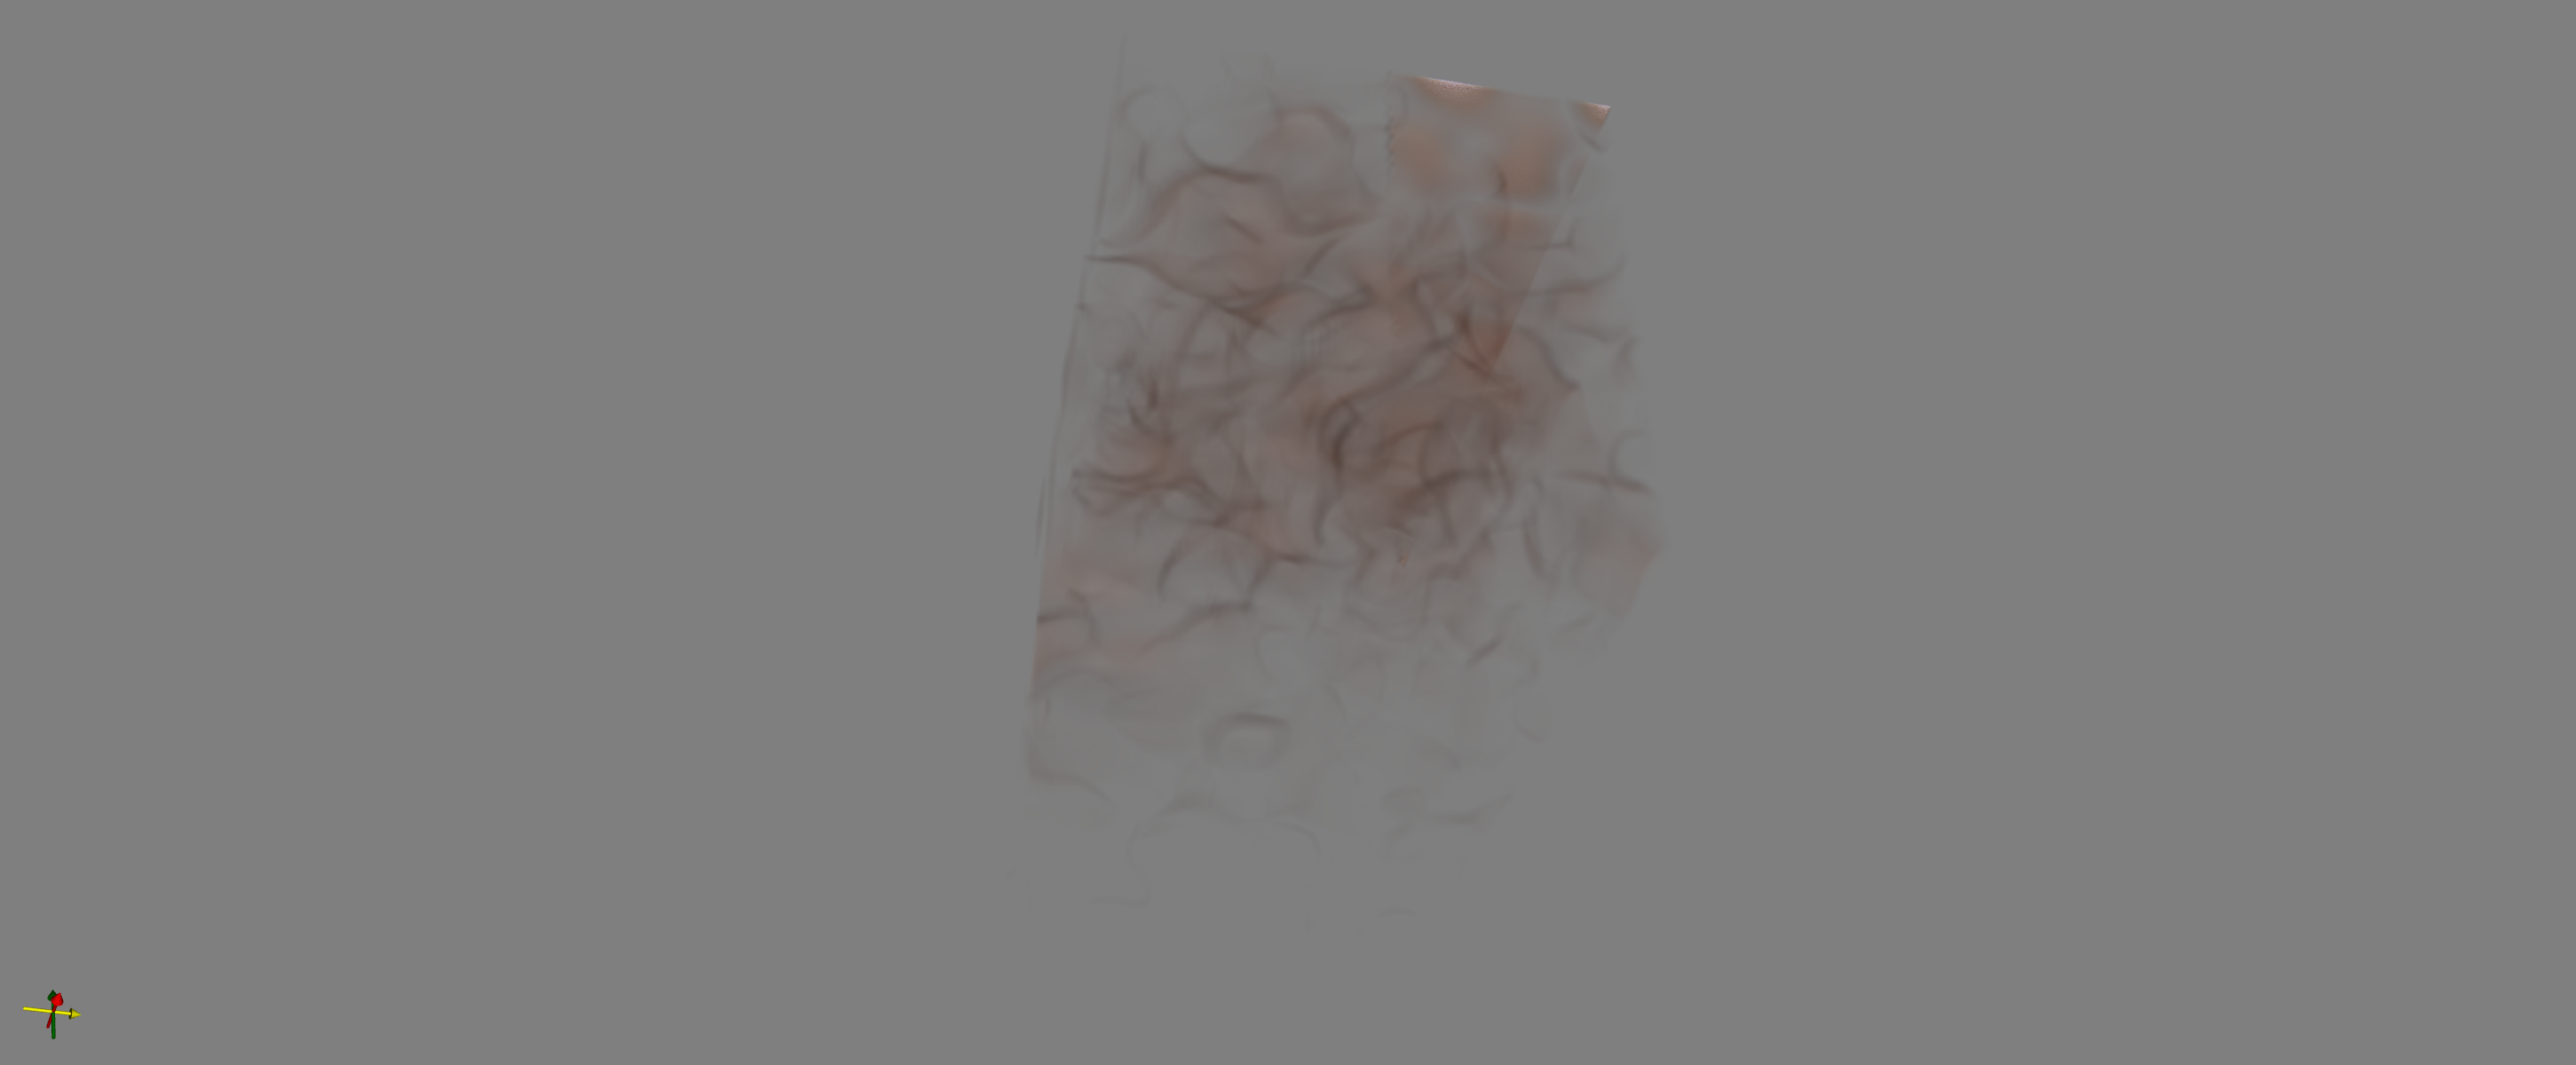

<IPython.core.display.Javascript object>

In [33]:
view(pre_diff-reg_diff)


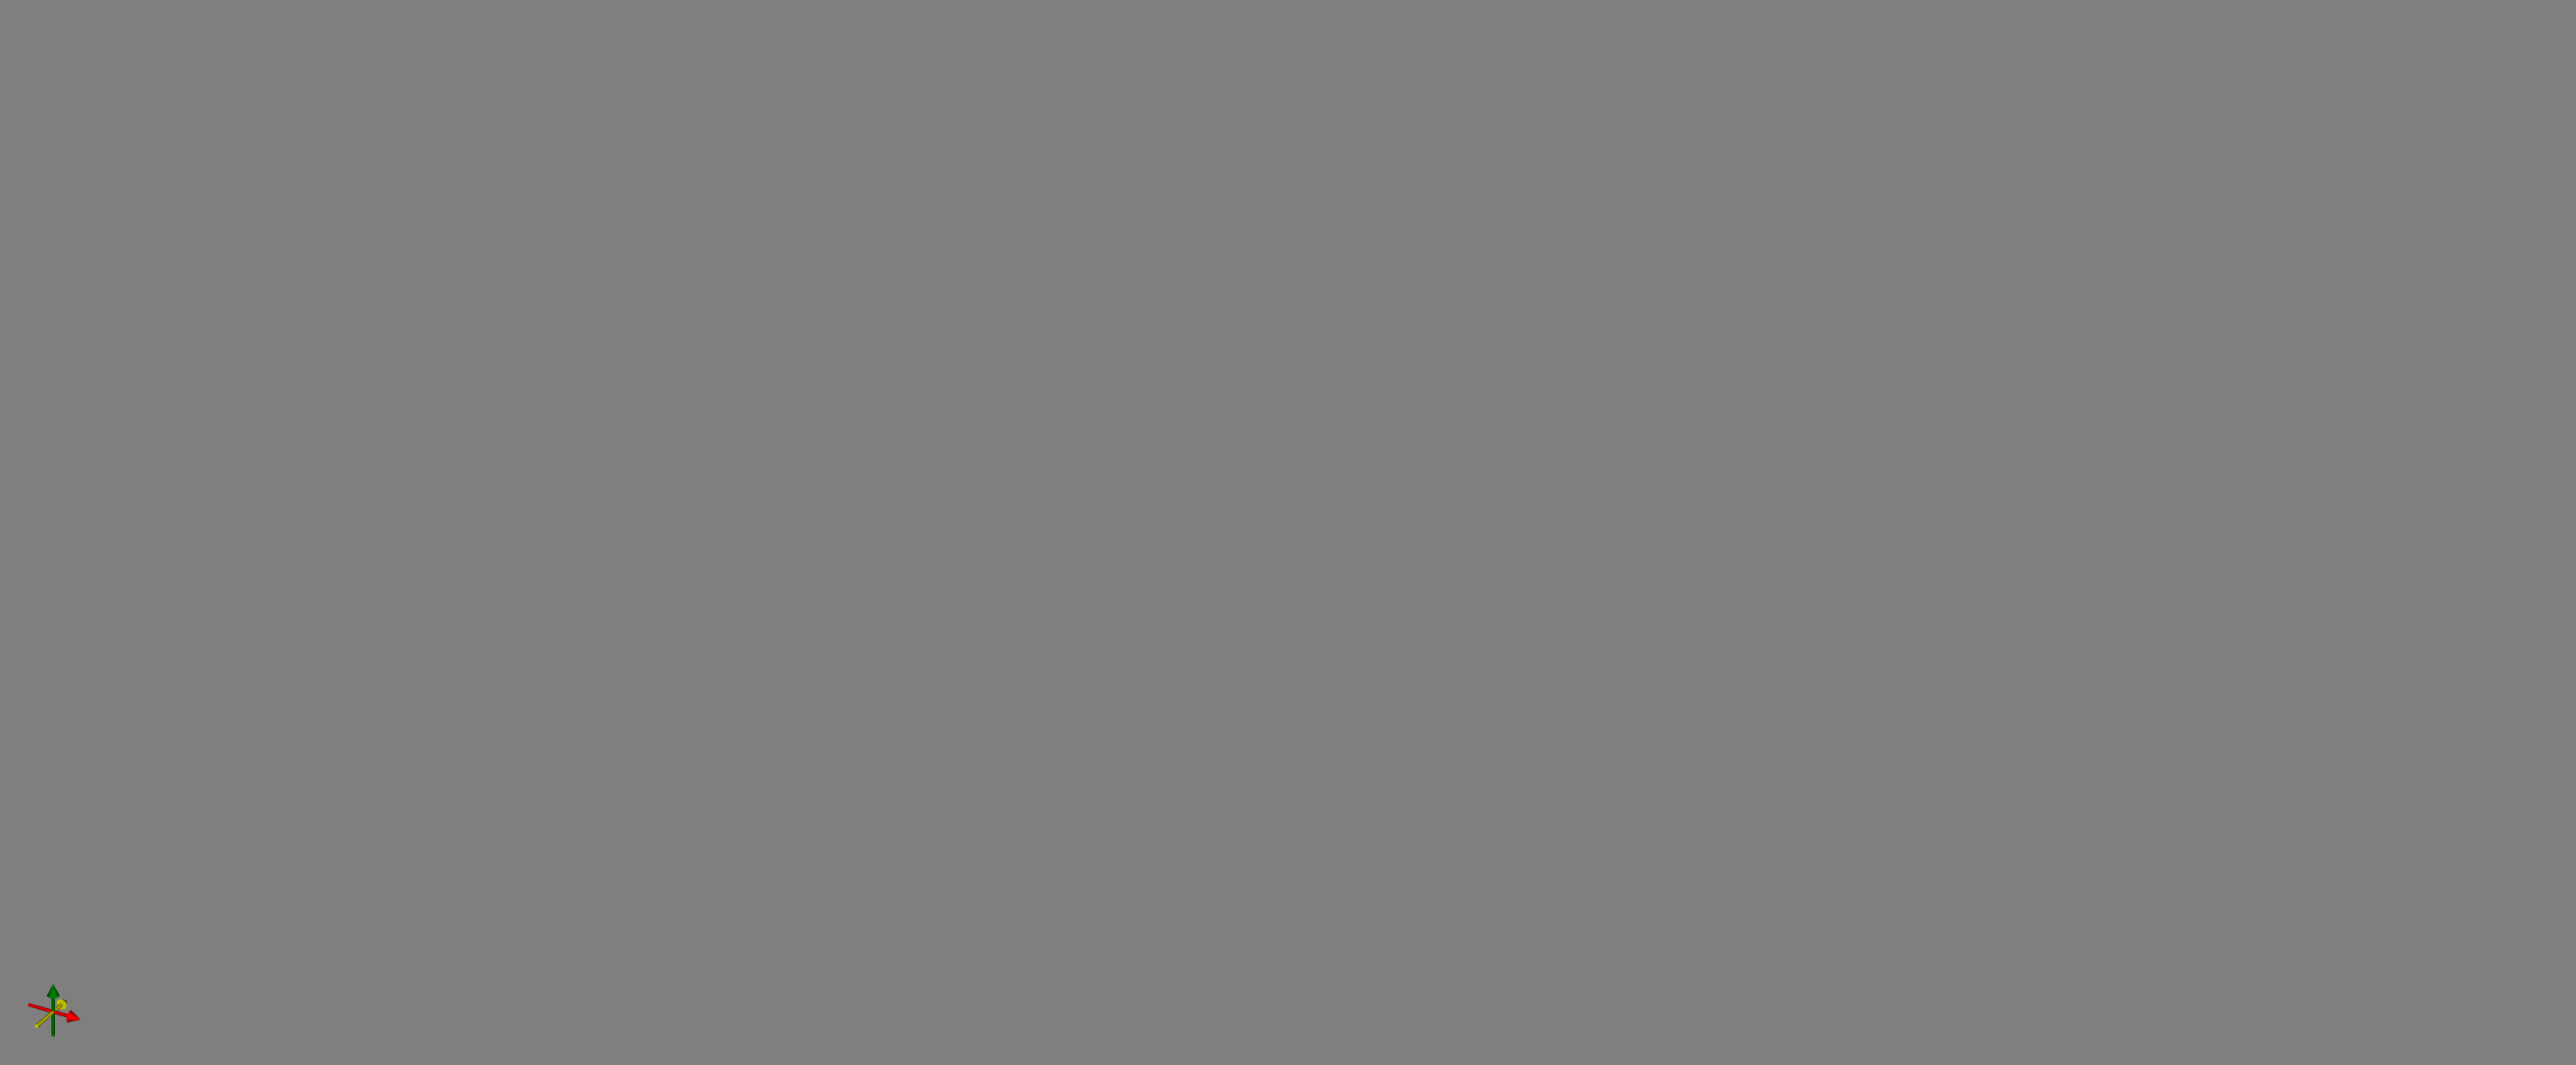
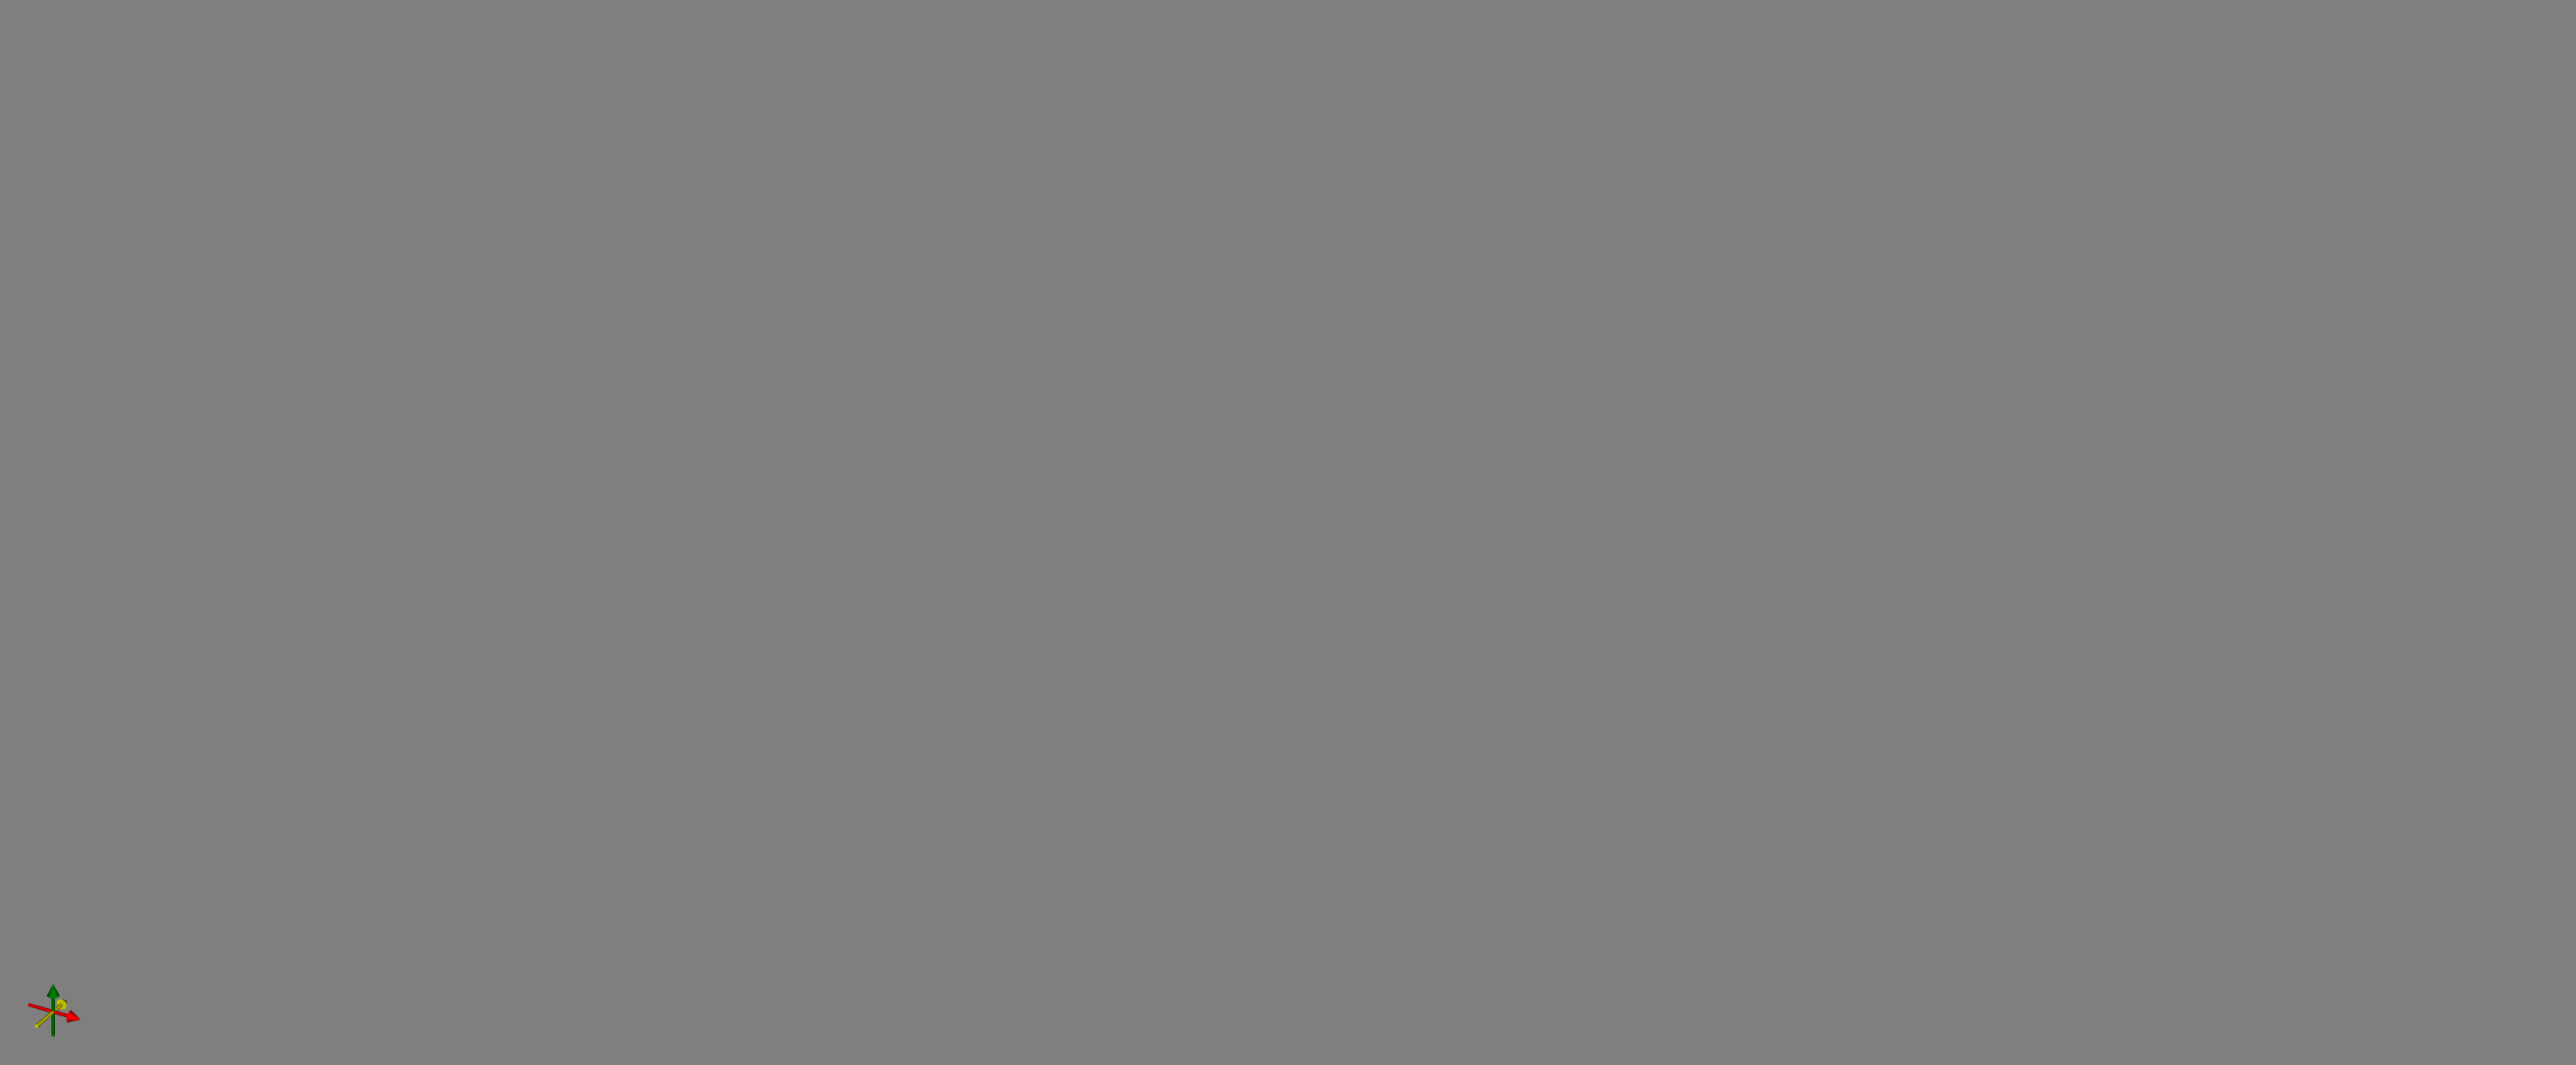

<IPython.core.display.Javascript object>

In [31]:
view(reg_diff)

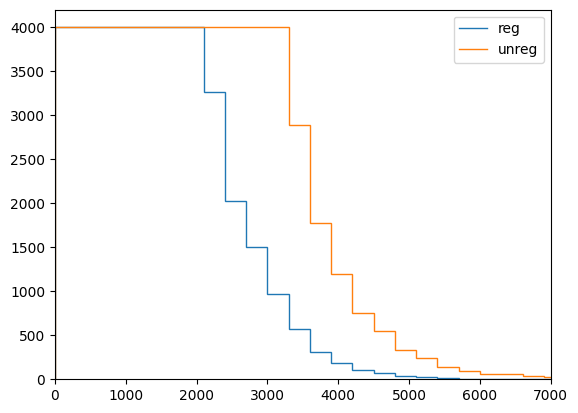

In [32]:
reg_counts, reg_bins = np.histogram(np.abs(reg_diff.flatten()),bins=500,range=(0,150000))
reg_counts = np.where(reg_counts>4000,4000, reg_counts)
fig = plt.figure()
plt.xlim(0,7000)
plt.stairs(reg_counts, reg_bins, label='reg'), plt.stairs(tmp_counts, tmp_bins, label='unreg')
plt.legend()